In [1]:
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

In [34]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap


SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
#         print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
#         print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
#         print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
#         print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
#         print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def knn_correction(expr, dosage, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

### Optimizes sb2 to a given Keff
#@timeit
def optimize_sb2(S, sigmasx, target):
    sbetas = list()
    S2 = np.square(S)
    S2_lim = np.percentile(S2, 50)
    for sx2 in sigmasx:
        sb2 =  sx2 / S2_lim       # start parameter at median
        S2mod = S2 + (sx2 / sb2)
        N = len(S2)
        Keff = np.sum(S2/S2mod) / N

        while np.abs(Keff - target) > 0.01:
            diff = Keff - target
            sb2 -= diff*(sb2)
            S2mod = S2 + (sx2 / sb2)
            Keff = np.sum(S2/S2mod) / N
        #print("Keff",Keff)
        #print("SB2=",sb2)
        sbetas.append(sb2)
    return np.array(sbetas)

In [3]:
# Use real genotype
chrm=12
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.01/GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 1000, samplefile=samplefile)


GT Sample selection 838 samples were retained from a total of 838 samples


In [4]:
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

Mode v26


In [7]:
# Load real expression
import pandas as pd
tissues=["wb"]

# for tissue in tissues:
tissue="wb"
# - No corrections
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
# # - CCLM no PC
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_cclm_nopc.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
# # - CCLM with PC
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_cclm.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
# # - TMM CCLM
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tmm/{:s}_tmm_cclm.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
# # - LASSO
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_lasso.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")

ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)
print(gx.shape)
print("Matrix rank:", np.linalg.matrix_rank(gx))


import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

## --- Obtain CisMasks
cismasklist = get_cismasklist(snp_info, genes, chrm, window=1e6)
cismaskcomp = compress_cismasklist(cismasklist)

gx_norm = normalize_expr( gx[:, exprmask] )
nsample = gx_norm.shape[1]

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

Y = gx_knn_norm
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)


(12046, 670)
Matrix rank: 669


In [135]:
import scipy.stats as ss

def tejaas_rr_single_SNP(myGT, myGX, sigmax2, sb2, j):
    it = 10000
    nsnps  = myGT.shape[0]
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    randQ  = np.zeros(it)
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    S2mod = S2 + (sigmax2 / sb2)
    Keff = np.sum(S2/S2mod) / len(S2)

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Rscore = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2

    pval, muQ, sigmaQ = pvals_perm(myGT[j, :].reshape(1, -1), Rscore, W)

    rand_gt = copy.deepcopy(myGT[j,:])
    for k in range(it):
        random.shuffle(rand_gt)
        randQ[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2      
        
    return pval, Rscore, muQ, sigmaQ, Keff, randQ

def shuffle_single_snp(GX, GT, sigmax2, cismasks = None):
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    multiplier = 0.5
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
    fig = plt.figure(figsize=(12,35), dpi=72)

    optimize = True
    max_k = 5
    k = 0
    l = 1
    h = 2
    stepsize = 0.1
    prev_sb2 = None
    while optimize and k < max_k:
        ax1 = fig.add_subplot(max_k,2,l)        
        ax2 = fig.add_subplot(max_k,2,h)
        if cismasks is not None:
            nmasks = len(cismasks)
            print("Found {:d} cismasks.".format(nmasks))
            for i,cismask in enumerate(cismasks):
                print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
                usegenes = np.ones(GX.shape[0], dtype=bool)
                if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
                myGX = GX[usegenes]
                myGT = GT[cismask.apply2,:]

                # Select SNP here based on..
                j = np.argsort(sigmax2)[0]
                
                if k == 0:
                    sb2 = optimize_sb2(S, [ sigmax2[j] ], 0.4)[0]
                    sb = np.sqrt(sb2)
                else:
                    step = stepsize*sb
                    sb += step
                    sb2 = sb * sb
                
                pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(myGT, myGX, sigmax2[cismask.apply2][j], sb2, j)
                print(f"SNP {j} | Q:{Q:g} | sx2:{sigmax2[j]:g} | sb:{sb} | Keff:{Keff}")
                
                ax1.hist(randQ, bins=50, alpha=0.3, density=True, label="sb={:g}|K={:g}".format(sb, Keff))
                ax1.axvline(Q, linestyle="--", color="red")

                x = np.linspace(muQ-4*sigmaQ, muQ+4*sigmaQ, 100)
                rv = stats.norm(loc = muQ, scale = sigmaQ)
                ax1.plot(x, rv.pdf(x), label = 'analytical')
                ax1.legend()
                
                scaled_randQ = (randQ - muQ) / sigmaQ
                res = stats.probplot(scaled_randQ, plot=ax2)
                fit_r2  = res[1][2] 
                print(f"r²:{fit_r2} | stepsize:{stepsize:g}")
                
        else:
            print("failed to provide cismask")
            raise
        k += 1
        l += 2
        h += 2
    plt.show()
    return pvals, Q, muQ, sigmaQ, sb2, Keff, randQ

Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
SNP 939 | Q:323.93 | sx2:0.0195352 | sb:0.0012548681227511345 | Keff:0.40808881692281634
r²:0.9999115564443587 | stepsize:0.1
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
SNP 939 | Q:349.271 | sx2:0.0195352 | sb:0.001380354935026248 | Keff:0.44714286339100007
r²:0.999346932443979 | stepsize:0.1
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
SNP 939 | Q:374.239 | sx2:0.0195352 | sb:0.0015183904285288726 | Keff:0.48644978388534715
r²:0.9994965022347986 | stepsize:0.1
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
SNP 939 | Q:398.534 | sx2:0.0195352 | sb:0.0016702294713817599 | Keff:0.525528422177292
r²:0.999068310487148 | stepsize:0.1
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
SNP 939 | Q:421.884 | sx2:0.0195352 | sb:0.0018372524185199359 | Keff:0.5639220132185202
r²:0.9982991265388614 | stepsize:0.1


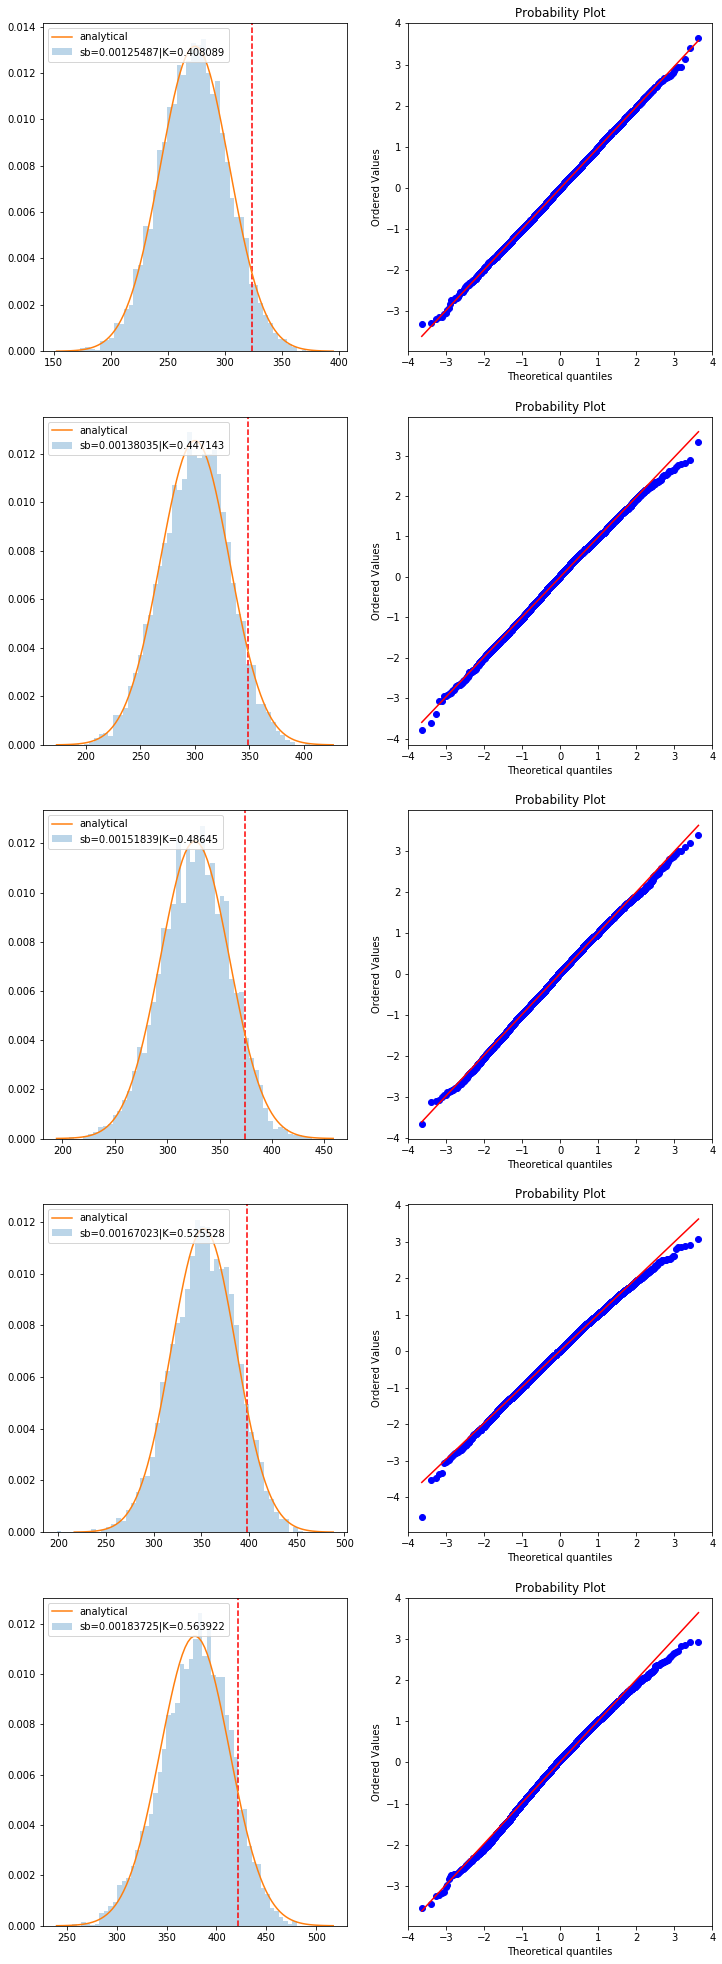

In [136]:
pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ= shuffle_single_snp( gx_knn_norm, 
                                                                 gt_knn_cent,
                                                                 sigmax2_knn,
                                                                 cismasks=cismaskcomp)

In [142]:
def get_qq_fit(gt, gx, sx2, sb2, j):
    pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(gt, gx, sx2, sb2, j)
    scaled_randQ = (randQ - muQ) / sigmaQ
    res = stats.probplot(scaled_randQ, fit=True)
    fit_r2  = res[1][2]
    amplitude = max(randQ) - min(randQ)
    print(f"SNP {j} | Q:{Q:g} | sx2:{sigmax2[j]:g} | sb:{np.sqrt(sb2)} | Keff:{Keff} | amp {amplitude}")
    return fit_r2, amplitude

def get_normal_sb_limit(GX, GT, sigmax2, cismasks = None):
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    sbetas = list()
    sigmas = list()
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    multiplier = 0.5
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )

    
    max_k = 20
    target_sx2 = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])

    if cismasks is not None:
        nmasks = len(cismasks)
        # print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            # print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(k, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            # Select SNP here based on..
            # j = np.argsort(sigmax2)[0]
            for t in target_sx2:
                max_sbs = list()
                j = np.argsort(np.abs(sigmax2 - t))[0]
                print(j, sigmax2[j], t)
                optimize = True
                k = 0
                stepsize = 0.1
                init_keff = 0.5
                while optimize and k < max_k:
                    if k == 0:
                        sb2 = optimize_sb2(S, [ sigmax2[j] ], init_keff)[0]
                        sb = np.sqrt(sb2)
                        r2, amp = get_qq_fit(myGT, myGX, sigmax2[cismask.apply2][j], sb2, j)
                        while r2 > 0.999:
                            init_keff += 0.1
                            sb2 = optimize_sb2(S, [ sigmax2[j] ], init_keff)[0]
                            sb = np.sqrt(sb2)
                            r2, amp = get_qq_fit(myGT, myGX, sigmax2[cismask.apply2][j], sb2, j)
                        sb2 = optimize_sb2(S, [ sigmax2[j] ], init_keff-0.1)[0]
                        sb = np.sqrt(sb2)
                        max_sbs.append(sb)
                    else:
                        # pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(myGT, myGX, sigmax2[cismask.apply2][j], sb2, j)
                        # print(f"SNP {j} | Q:{Q:g} | sx2:{sigmax2[j]:g} | sb:{sb} | Keff:{Keff}")
                        r2, amp = get_qq_fit(myGT, myGX, sigmax2[cismask.apply2][j], sb2, j)
                        
                    if r2 > 0.999:
                        if amp < 30:
                            sb -= stepsize*sb
                            sb2 = sb*sb
                        else:
                            if sb > max(max_sbs):
                                max_sbs.append(sb)
                            step = stepsize*sb
                            sb += step
                            sb2 = sb * sb
                    if r2 < 0.999:
                        if len(max_sbs)> 1 and np.abs( sb - max(max_sbs) ) < 0.0001:
                            optimize = False
                            print("diff success")
                        else:
                            sb -= stepsize*sb*0.5
                            sb2 = sb*sb
                    print(f"r²:{r2}")
                    k += 1
                sbetas.append(sb)
                sigmas.append(sigmax2[cismask.apply2][j])
    else:
        print("failed to provide cismask")
        raise
    return sbetas, sigmas

sbetas, sigmas = get_normal_sb_limit( gx_knn_norm, 
                                      gt_knn_cent,
                                      sigmax2_knn,
                                      cismasks=cismaskcomp)

939 0.01953516992153659 0.01
SNP 939 | Q:377.461 | sx2:0.0204589 | sb:0.0015374367032801662 | Keff:0.4915840148758015 | amp 220.87440278264145
SNP 939 | Q:437.407 | sx2:0.0204589 | sb:0.001962886715161077 | Keff:0.5899443878900497 | amp 227.42216842971663
r²:0.9989129478348081
SNP 939 | Q:364.132 | sx2:0.0204589 | sb:0.0014605648681161579 | Keff:0.47043749680620156 | amp 234.39792746855196
r²:0.999567779447549
SNP 939 | Q:388.736 | sx2:0.0204589 | sb:0.0016066213549277737 | Keff:0.5096661431804129 | amp 232.99163316752544
r²:0.999284160390536
SNP 939 | Q:412.502 | sx2:0.0204589 | sb:0.001767283490420551 | Keff:0.5483915057342655 | amp 229.0505744503736
r²:0.9990177096306813
SNP 939 | Q:435.178 | sx2:0.0204589 | sb:0.0019440118394626062 | Keff:0.5861809554440279 | amp 229.67553370903295
r²:0.9981514102467655
SNP 939 | Q:423.124 | sx2:0.0204589 | sb:0.0018468112474894758 | Keff:0.5659843800230828 | amp 242.27001965932993
diff success
r²:0.9987674245249448
579 0.049682968243360305 0.05
SN

SNP 223 | Q:541.46 | sx2:0.215202 | sb:0.012334111633359051 | Keff:0.8056782441183047 | amp 77.04901838101489
r²:0.9993317943479125
SNP 223 | Q:555.026 | sx2:0.215202 | sb:0.013567522796694957 | Keff:0.8276222370941593 | amp 78.93179328530044
r²:0.9976667015261935
SNP 223 | Q:547.874 | sx2:0.215202 | sb:0.01288914665686021 | Keff:0.8160697117198797 | amp 71.86320360871315
r²:0.9985474222990052
SNP 223 | Q:540.375 | sx2:0.215202 | sb:0.012244689324017198 | Keff:0.803917326186321 | amp 77.22215988662339
r²:0.9988108801701476
178 0.30243300908393356 0.3
SNP 178 | Q:334.546 | sx2:0.29816 | sb:0.006049273822790344 | Keff:0.4915840148758015 | amp 67.35749894539657
SNP 178 | Q:398.413 | sx2:0.29816 | sb:0.007723270296457226 | Keff:0.5899443878900497 | amp 71.32379105587694
SNP 178 | Q:464.042 | sx2:0.29816 | sb:0.010199684730999078 | Keff:0.6911027279269323 | amp 58.23576541084907
SNP 178 | Q:529.019 | sx2:0.29816 | sb:0.014307707351476812 | Keff:0.7910615533884016 | amp 66.00377521200886
SNP

SNP 55 | Q:595.482 | sx2:0.480428 | sb:0.027884268827497574 | Keff:0.8777189443029597 | amp 33.26102407590929
r²:0.9995366058489741
SNP 55 | Q:604.769 | sx2:0.480428 | sb:0.030672695710247333 | Keff:0.8926704920566608 | amp 30.712647614219122
r²:0.999787741099185
SNP 55 | Q:613.03 | sx2:0.480428 | sb:0.033739965281272065 | Keff:0.9060373678215534 | amp 29.795398613737348
r²:0.9993419163625288
SNP 55 | Q:603.84 | sx2:0.480428 | sb:0.03036596875314486 | Keff:0.8911707913188301 | amp 30.472408001103304
r²:0.9997712347915637
SNP 55 | Q:612.205 | sx2:0.480428 | sb:0.03340256562845934 | Keff:0.904698856637748 | amp 25.642613266443504
r²:0.9997225952860057
SNP 55 | Q:602.899 | sx2:0.480428 | sb:0.030062309065613406 | Keff:0.8896533228887906 | amp 28.716112893217087
r²:0.9998193592545958
SNP 55 | Q:592.317 | sx2:0.480428 | sb:0.027056078159052064 | Keff:0.8726389960926246 | amp 30.555377701197926
r²:0.9996427262808075
SNP 55 | Q:601.947 | sx2:0.480428 | sb:0.02976168597495727 | Keff:0.88811793

In [143]:
print(sbetas, sigmas)

[0.0018468112474894758, 0.002658060685434013, 0.008531818876649219, 0.01029916846819338, 0.011632454857816337, 0.022219432011946472, 0.029600569999834698, 0.023627237023485053] [0.01953516992153659, 0.049682968243360305, 0.09992173708571571, 0.1502723793965496, 0.19976551322987054, 0.30243300908393356, 0.40033657830251723, 0.5004472686319645]


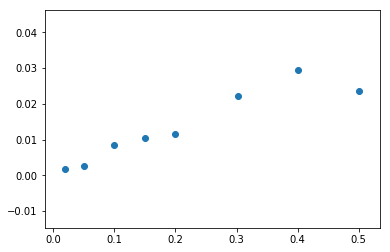

In [144]:
plt.scatter(sigmas, sbetas)
plt.show()

In [116]:
target_sx2 = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])
for t in target_sx2:
    ix = np.argsort(np.abs(sigmax2_knn - t))[0]
    print(ix, sigmax2_knn[ix], t)


939 0.01953516992153659 0.01
579 0.049682968243360305 0.05
240 0.09992173708571571 0.1
209 0.1502723793965496 0.15
223 0.19976551322987054 0.2
178 0.30243300908393356 0.3
379 0.40033657830251723 0.4
55 0.5004472686319645 0.5
